In [5]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install pylatexenc
# %pip install tensorflow
# %pip install ipywidgets
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning

In [1]:
import os
from IPython.display import clear_output
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.circuit.library import ZFeatureMap
import torch
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array

#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [2]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Define dataset paths

In [3]:
dataset_path = f'{path}/brain_tumor_dataset/'
validation_path_yes = f'{path}/yes'
validation_path_no = f'{path}/no'

#### Check data

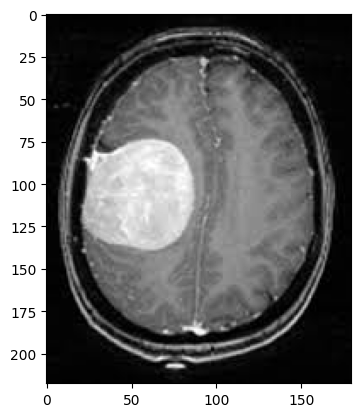

In [4]:
mri_image = cv2.imread(f'{dataset_path}yes/Y1.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

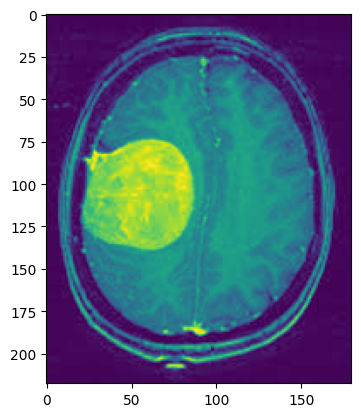

In [5]:
transform = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Image size & Categories

In [6]:
img_size = (128, 128)
categories = ['no', 'yes']

#### Loading and preprocessing images

In [7]:
data = []
labels = []

for label, category in enumerate(categories):
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(img_size)
            img_array = img_to_array(img) / 255.0
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")

#### Converting data and labeling to numpy arrays

In [8]:
data = np.array(data)
labels = np.array(labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [10]:
X_train_res = X_train.reshape(-1, 8)
X_test_res = X_test.reshape(-1, 8)

#### Reshape & Apply PCA

In [11]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train_res)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

In [12]:
X_test_pca = pca.transform(X_test_res)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### Create layers

#### Convolutional Layer

In [13]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target


def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    if num_qubits % 2 == 0:
        for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
            qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
            qc.barrier()
            param_index += 3
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc

#### Pooling Layer

In [14]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    return target


def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3
        
    qc_inst = qc.to_instruction()
    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc

#### Create & Visualize the QNN

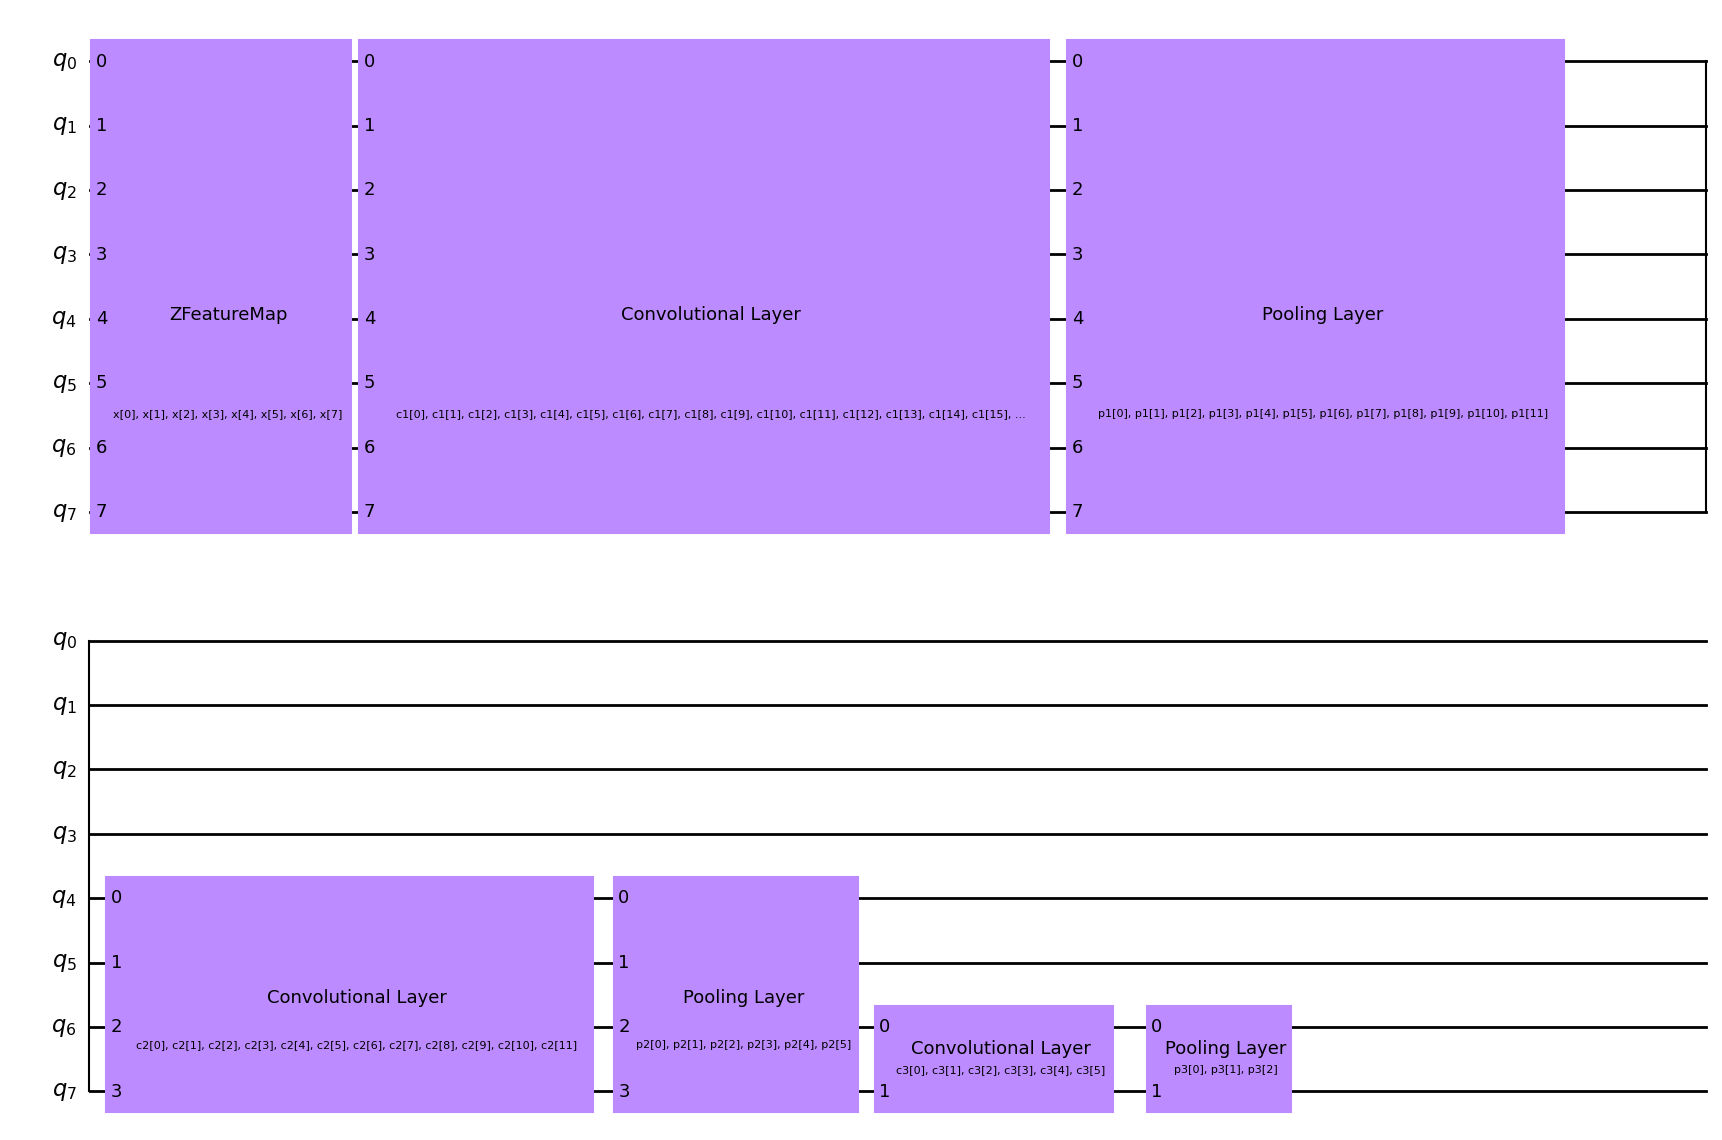

In [15]:
num_qubits = 8
feature_map = ZFeatureMap(num_qubits)
ansatz = QuantumCircuit(num_qubits, name="Ansatz")

ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)
ansatz.compose(conv_layer(4, "c2"), list(range(4, 8)), inplace=True)
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4, 8)), inplace=True)
ansatz.compose(conv_layer(2, "c3"), list(range(6, 8)), inplace=True)
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6, 8)), inplace=True) 

circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
circuit.draw("mpl", style="clifford")

#### Objective function visualization

In [17]:
objective_func_vals = []

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

#### Train with SPSA optimizer

In [18]:
classifier = NeuralNetworkClassifier(
    neural_network=qnn,
    optimizer=SPSA(maxiter=30, learning_rate=0.02, perturbation=0.01),
    loss='cross_entropy',
    callback=callback_graph 
)

classifier.fit(X_train_pca, y_train)

KeyboardInterrupt: 

In [ ]:
train_accuracy = np.round(100 * classifier.score(X_train_tensor, y_train_tensor), 2)
print(f"Accuracy from the training data: {train_accuracy}%")
print("***************************************************")
test_accuracy = np.round(100 * classifier.score(X_test_tensor, y_test_tensor), 2)
print(f"Accuracy from the test data: {test_accuracy}%")
predictions = classifier.predict(X_test_tensor)
print("***************************************************")
accuracy = np.mean(predictions == y_test_tensor.numpy())
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright